In [2]:
from model import LGBMTuning
import lightgbm as lgb
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd

# Sample data preparation

In [22]:
dataset = make_classification(n_samples=10000, n_features=20, 
                              n_informative=3, n_classes=2, shift=2,
                              scale=2000, random_state=123)

In [23]:
data = pd.DataFrame(dataset[0], columns=['col_{}'.format(i) for i in range(1, 21)])
data['y'] = dataset[1]
target = 'y'

In [24]:
np.random.seed(123)
data['col_21'] = np.random.choice(a=[0, 1, 2], 
                                  size=10000,  
                                  p=[0.5, 0.3, 0.2])
data['col_22'] = np.random.choice(a=[1, 5, 9], 
                                  size=10000,  
                                  p=[0.5, 0.3, 0.2])

In [25]:
for i in range(1, 23):
    np.random.seed(123+i)
    data.loc[np.random.randint(0, 10000, size=500), 'col_'+str(i)] = np.nan

In [29]:
for col in ['col_21', 'col_22']:
    data[col] = data[col].astype('category')

In [31]:
x = data.drop(target, axis=1)
y = data[target]

# Model setup

In [32]:
n_comb = 10
n_fold = 5

tuning = LGBMTuning()

tuning.param_grid['learning_rate'] = [0.03, 0.05, 0.075, 0.1]
tuning.param_grid['min_child_sample'] = [100, 200, 300]
tuning.param_grid['min_child_weight'] = [50, 150, 300]
tuning.param_grid['subsample'] = [0.7, 0.8, 1]
tuning.param_grid['n_jobs'] = [-1]
tuning.param_grid['reg_alpha'] = [1, 5, 10, 20, 50, 80, 100, 150, 200]
tuning.param_grid['reg_lambda'] = [1, 5, 10, 30, 50, 80, 100, 150, 200]
tuning.param_grid['num_leaves'] = [30, 50, 70, 90, 100]
tuning.param_grid

{'objective': ['binary'],
 'boosting': ['gbdt'],
 'n_estimator': [2500],
 'num_leaves': [30, 50, 70, 90, 100],
 'min_child_sample': [100, 200, 300],
 'min_child_weight': [50, 150, 300],
 'max_depth': [7, 9, 11, 13, 15],
 'learning_rate': [0.03, 0.05, 0.075, 0.1],
 'reg_alpha': [1, 5, 10, 20, 50, 80, 100, 150, 200],
 'reg_lambda': [1, 5, 10, 30, 50, 80, 100, 150, 200],
 'colsample_bytree': [0.7, 0.8],
 'max_bin': [255, 355],
 'subsample': [0.7, 0.8, 1],
 'n_jobs': [-1]}

## RFE

In [33]:
np.random.seed(123)
tuning.lgb_rfe(X=x, y=y, 
               param={
                   'boosting':'gbdt', 
                   'colsample_bytree': 0.8, 
                   'learning_rate': 0.03, 
                   'max_bin':255, 
                   'max_depth':9, 
                   'min_child_sample':100, 
                   'min_child_weight':50, 
                   'num_leaves': 90, 
                   'reg_alpha': 100, 
                   'reg_lambda': 1, 
                   'subsample':1, 
                   'objective': 'binary', 
                   'n_estimator': 2500
               }, step=1, 
               metrics='auc', 
               nfold=n_fold, 
               min_features=10, 
               early_stopping_rounds=5)

22 with mean valid auc: 0.8933 -- 0s
21 with mean valid auc: 0.8729 -- 0s
20 with mean valid auc: 0.8937 -- 0s
19 with mean valid auc: 0.8909 -- 0s
18 with mean valid auc: 0.8867 -- 0s
17 with mean valid auc: 0.8948 -- 0s
16 with mean valid auc: 0.8867 -- 0s
15 with mean valid auc: 0.8901 -- 0s
14 with mean valid auc: 0.8845 -- 0s
13 with mean valid auc: 0.8908 -- 0s
12 with mean valid auc: 0.8859 -- 0s
11 with mean valid auc: 0.8948 -- 0s
10 with mean valid auc: 0.8929 -- 0s


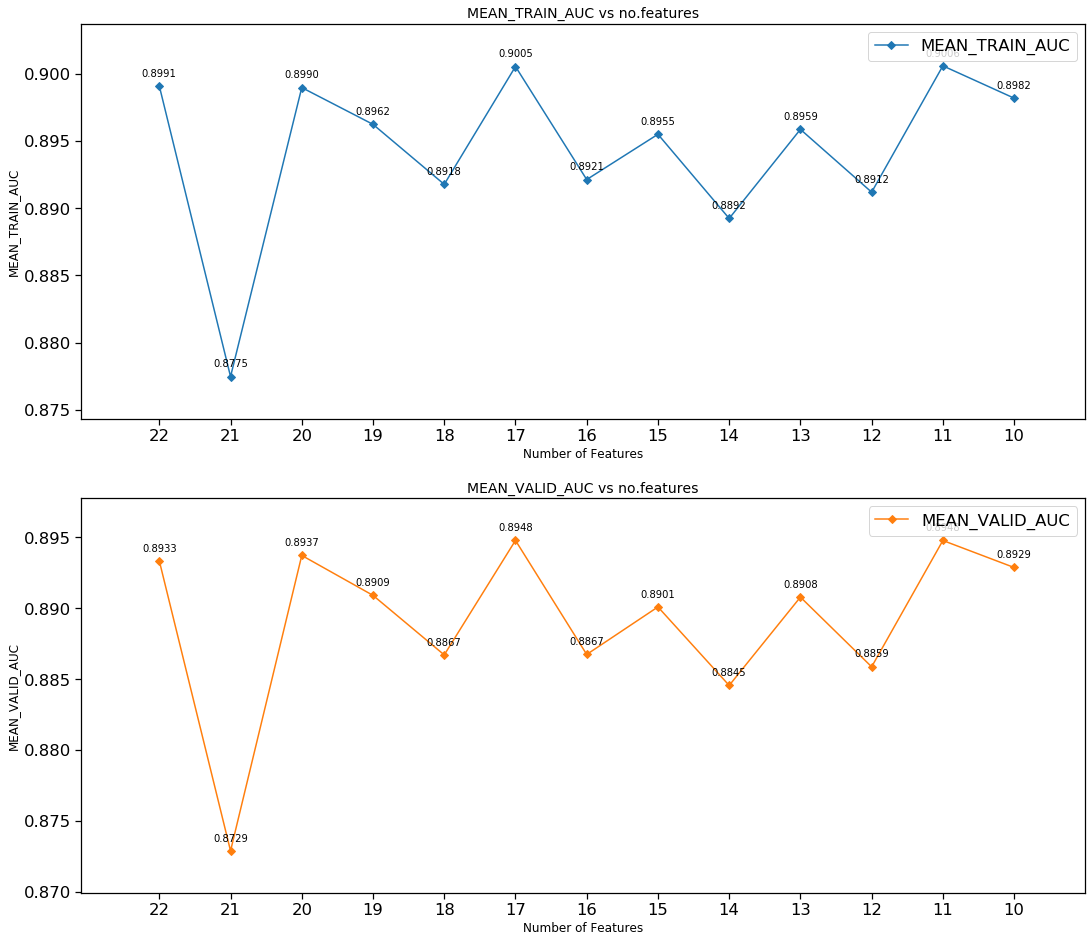

In [34]:
tuning.plot_rfe()

In [41]:
# -1 is self picked based on plots
columns = tuning.rfe_feature_list[-1]

## Hyperparameter-tuning

In [35]:
np.random.seed(123)
tuning.lgb_randomized_search_cv(X=x[columns], 
                                y=y, metrics='auc', 
                                nfold=n_fold, n_comb=n_comb, 
                                early_stopping_rounds=5)

Finished 1/10 cv with mean valid auc: 0.8841 -- 7s
Finished 2/10 cv with mean valid auc: 0.9384 -- 8s
Finished 3/10 cv with mean valid auc: 0.8722 -- 10s
Finished 4/10 cv with mean valid auc: 0.9244 -- 15s
Finished 5/10 cv with mean valid auc: 0.9087 -- 18s
Finished 6/10 cv with mean valid auc: 0.9087 -- 20s
Finished 7/10 cv with mean valid auc: 0.9174 -- 17s
Finished 8/10 cv with mean valid auc: 0.9458 -- 22s
Finished 9/10 cv with mean valid auc: 0.8994 -- 19s
Finished 10/10 cv with mean valid auc: 0.9140 -- 16s


In [36]:
tuning.search_result.sort_values('mean_valid_auc', ascending=False)

,model_idx,mean_train_auc,mean_valid_auc,best_n_estimators,train_valid_diff
7,7,0.983271,0.945800,2500,0.037470
1,1,0.950086,0.938374,2500,0.011712
3,3,0.933317,0.924362,2500,0.008954
6,6,0.930476,0.917374,2500,0.013103
9,9,0.922250,0.914007,2500,0.008243
4,4,0.915869,0.908651,2500,0.007218
5,5,0.915869,0.908651,2500,0.007218
8,8,0.906472,0.899447,2500,0.007025
0,0,0.890003,0.884066,2500,0.005937
2,2,0.877431,0.872247,2500,0.005184


In [39]:
parameters = {}
parameters.update(tuning.param_combs[7])
parameters.update({'metrics':'auc'})
del parameters['early_stopping_rounds']
parameters

{'boosting': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 11,
 'min_child_sample': 200,
 'min_child_weight': 50,
 'n_jobs': -1,
 'num_leaves': 50,
 'objective': 'binary',
 'reg_alpha': 1,
 'reg_lambda': 80,
 'subsample': 0.8,
 'metrics': 'auc'}

## Train data on full data

In [42]:
np.random.seed(123)
train_set = lgb.Dataset(data=x[columns], label=y)
lgb_model = lgb.train(params=parameters, 
                      feature_name=columns, num_boost_round=2500, train_set=train_set)

# Save model

In [ ]:
pickle.dump(lgb_model, open(model_path + 'lgb_model.pkl', 'wb'))